In [1]:
import warnings

warnings.filterwarnings("ignore")

# Lab Week 12: Inequality

This week's lesson is a simplied version of:
- https://github.com/pysal/segregation/blob/main/notebooks/01_singlegroup_indices.ipynb
- https://github.com/pysal/segregation/blob/main/notebooks/04_multiscalar_example.ipynb


## Data Prep: Sacramento

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.examples import load_example

In [3]:
# read in sacramento data from libpysal and reproject into an appropriate CRS
sacramento = gpd.read_file(load_example("Sacramento1").get_path("sacramentot2.shp"))
sacramento = sacramento.to_crs(sacramento.estimate_utm_crs())

In [4]:
sacramento.head()

,FIPS,MSA,TOT_POP,POP_16,POP_65,WHITE,BLACK,ASIAN,HISP,MULTI_RA,...,EMP_FEM,OCC_MAN,OCC_OFF1,OCC_INFO,HH_INC,POV_POP,POV_TOT,HSG_VAL,POLYID,geometry
0,06061022001,Sacramento,5501,1077,518,4961,29,82,336,31,...,1187,117,663.0,42,52941,5461,470,225900,1,"POLYGON ((740409.853 4338451.728, 740199.864 4..."
1,06061020106,Sacramento,2072,396,109,1603,0,28,391,41,...,522,38,229.0,19,51958,2052,160,249300,2,"POLYGON ((753400.378 4347151.080, 753395.816 4..."
2,06061020107,Sacramento,3633,911,126,1624,9,0,1918,41,...,698,86,197.0,0,32992,3604,668,175900,3,"POLYGON ((758318.262 4352123.456, 758319.774 4..."
3,06061020105,Sacramento,1683,281,154,1564,0,55,60,4,...,519,5,256.0,6,54556,1683,116,302300,4,"POLYGON ((750839.595 4342678.807, 750805.840 4..."
4,06061020200,Sacramento,5794,1278,830,5185,17,13,251,229,...,1260,155,506.0,59,50815,5771,342,167300,5,"POLYGON ((670062.020 4311030.409, 670133.819 4..."


<Axes: >

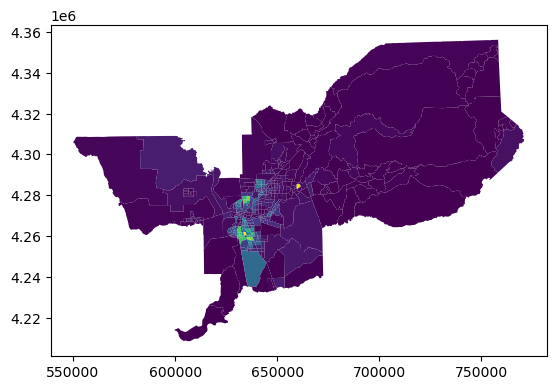

In [5]:
sacramento.plot('BLACK')

## Network Distance-based Inequality Measures

Instead of a euclidian distance-based kernel, each generalized spatial segregation index can be calculated using accssibility analysis on a transportation network instead. Since people can't fly, using a travel network to measure spatial distances is more conceptually pure to the spirit of segregation indices 

In [9]:
import pandana as pdna
from segregation.singlegroup import AbsoluteCentralization, Gini

A network can be created using the [urbanaccess](https://github.com/UDST/urbanaccess) package, or the built-in `get_osm_network` function from the `segregation.util` module. Alternatively, metropolitan-scale networks from OpenStreetMap are also available in the [CGS quilt bucket](https://open.quiltdata.com/b/spatial-ucr/tree/osm/) (named by CBSA FIPS code)

In [10]:
net = pdna.Network.from_hdf5('40900.h5')

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 377311
Setting CH edge vector of size 588982
Range graph removed 163420 edges of 1177964
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [11]:
network_spatialgini = Gini(sacramento, group_pop_var='BLACK', 
                           total_pop_var='TOT_POP', distance=2000, 
                           network=net, decay='linear')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Comparing spatial gini indices based on straight-line distance versus network distance:

In [12]:
network_spatialgini.statistic

0.0

## Batch-Computing Single-Group Measures

To compute all single group indices in one go, the package provides a wrapper function in the `batch` module

In [13]:
from segregation.batch import batch_compute_singlegroup

In [14]:
all_singlegroup = batch_compute_singlegroup(sacramento, group_pop_var='BLACK', total_pop_var='TOT_POP')

  0%|          | 0/27 [00:00<?, ?it/s]

In [15]:
all_singlegroup

,Statistic
Name,
AbsoluteCentralization,0.8492
AbsoluteClustering,0.0610
AbsoluteConcentration,0.9814
Atkinson,0.3659
BiasCorrectedDissim,0.4876
BoundarySpatialDissim,0.4501
ConProf,0.1128
CorrelationR,0.1010
Delta,0.9073


# Multiscalar Segregation Profiles

For measuring spatial segregation dynamics, the `segregation` package provides a function for measuring multiscalar segregation profiles, as introduced by [Reardon et al](http://link.springer.com/10.1353/dem.0.0019).
The multiscalar profile is a tool for measuring spatial segregation dynamics--the way that a segregation index changes values as the concept of a neighborhood changes, and what that tells us about macro versus micro patterns of segregation. 

The basic idea is to calculate a segregation statistic, then expand the spatial scope of a neighborhood, recalculate the statistic, and repeat. 
A multiscalar profile can be computed for any generalized spatial segregation index, which in the case of the `segregation` package, means a total of 23 indices, including single and multigroup varieties

In [16]:
from segregation.singlegroup import Dissim, Gini
from segregation.dynamics import compute_multiscalar_profile
from segregation.batch import implicit_multi_indices, implicit_single_indices

In [17]:
len(implicit_single_indices) + len(implicit_multi_indices)

23

In [18]:
sac_gini_profile =  compute_multiscalar_profile(sacramento, segregation_index=Gini, 
                                                group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                distances= range(500,5500,500))

The function returns a pandas Series whose index is the neighborhood distance threshold, and the value is the segregation statistic.

In [19]:
sac_gini_profile

distance
0       0.636176
500     0.636060
1000    0.623794
1500    0.585519
2000    0.536802
2500    0.499355
3000    0.472811
3500    0.452414
4000    0.436664
4500    0.424351
5000    0.412981
Name: Gini, dtype: float64

As such, the profile is easy to plot:

<Axes: xlabel='distance'>

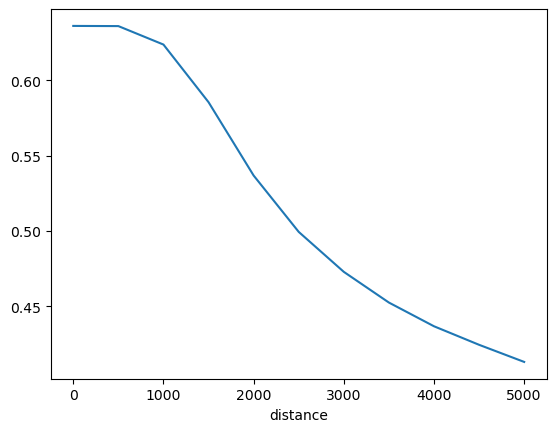

In [20]:
sac_gini_profile.plot()

A good way to compare multiscalar profiles is to plot them in the same figure. For example to compare profiles for gini and dissimilarity indices:

In [21]:
sac_dissim_profile = compute_multiscalar_profile(sacramento, segregation_index=Dissim,
                                                group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                distances= range(500,5500,500))

In [22]:
from libpysal.weights import DistanceBand

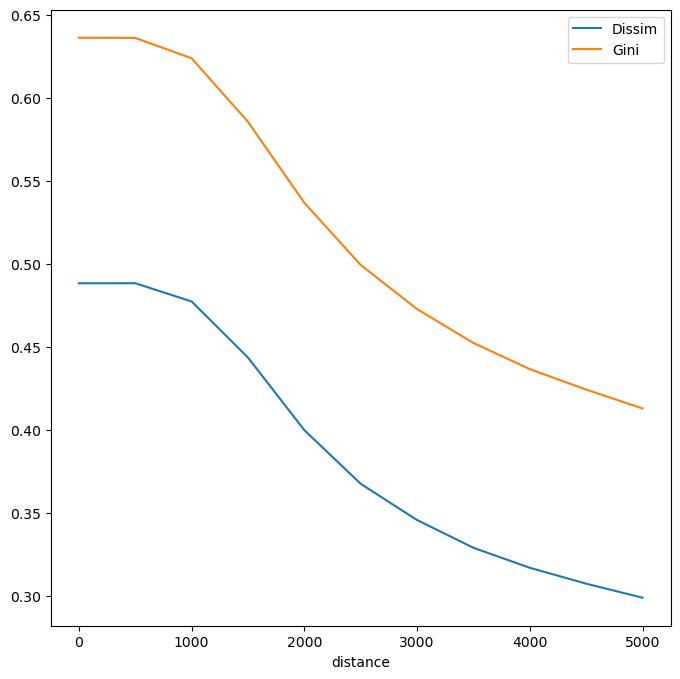

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

sac_dissim_profile.plot(ax=ax)
sac_gini_profile.plot(ax=ax)
ax.legend()

The multiscalar profiles for Gini and Dissimilarity indices are very similar, but have slightly different shapes. 

### Network versus Euclidian Multiscalar Profiles

To calculate a multiscalar profile using travel network distance instead of Euclidian distance, simply pass a `pandana.Network` object to the function

In [24]:
import pandana as pdna

However, due to the lengthy computation time, I have turned off the execution of this section. I've included the code for your reference.

In [32]:
#net = pdna.Network.from_hdf5("40900.h5")

In [27]:
#net_dissim_profile = compute_multiscalar_profile(sacramento, segregation_index=Dissim,
                                                #group_pop_var="BLACK", total_pop_var="TOT_POP", 
                                                #network = net,
                                                #distances= range(500,5500,500))

In [28]:
#fig, ax = plt.subplots(figsize=(8,8))

#sac_dissim_profile.name='Dissim'
#net_dissim_profile.name='Network Dissim'
#sac_dissim_profile.plot(ax=ax)
#net_dissim_profile.plot(ax=ax)
#ax.legend()

In this case, comparing the two profiles reveals the role of travel infrastructure on the experience and measurement of segregation; the network-based dissimilarity profile falls slower, indicating that travel networks help insulate segregation at larger distances

## Computing a Multi Group Profile

To calculate a multigroup index (e.g. the multigroup information theory index from the original paper), simply pass a MultiGroupIndex class to the function with multigroup arguments instead of singlegroup

In [29]:
from segregation.multigroup import MultiInfoTheory, MultiGini

In [30]:
multi_info_profile = compute_multiscalar_profile(sacramento, segregation_index=MultiInfoTheory, 
                                          groups=["HISP", 'BLACK', "WHITE"], distances=range(500,5000,500))

multi_gini_profile = compute_multiscalar_profile(sacramento, segregation_index=MultiGini, 
                                          groups=["HISP", 'BLACK', "WHITE"], distances=range(500,5000,500))

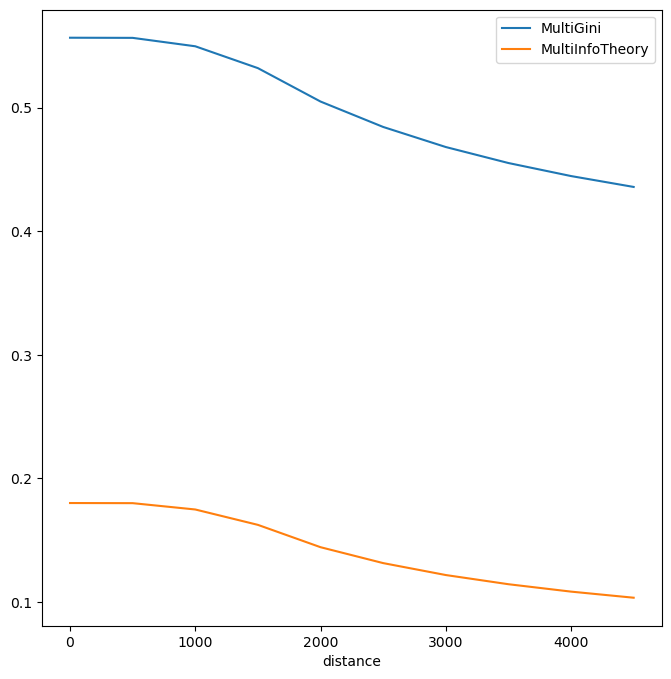

In [31]:
fig, ax = plt.subplots(figsize=(8,8))

multi_gini_profile.plot(ax=ax)
multi_info_profile.plot(ax=ax)
ax.legend()